# Lab 2: Linear and nonlinear dimensionality reduction

In this lab, you'll use [NumPy](https://numpy.org/) and [PyTorch](https://pytorch.org/) to build Prinicpal Components Analysis (PCA), Autoencoder, and Gaussian Process Factor Analysis (GPFA) (optional), and to a Calcium Imaging dataset or a synthetic dataset. 

In [2]:
using_colab = False
# install some required python packages 
!pip3 install neo elephant --quiet

In [3]:
if using_colab:
    import sys
    from google.colab import drive
    drive.mount('/content/gdrive/')
    sys.path.append('/content/gdrive/MyDrive/CSE8803_ML_for_Neural_Behavioral_Data/')

In [4]:
from tqdm import trange
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

from scipy.io import loadmat

from elephant.gpfa import GPFA

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import numpy as np

from utils import train_ae, generate_syn_data

device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
print(device)

cuda


## Load the data

Load the file `v1_spike_data.mat` into Python. You'll find a matrix `Msp` , which contains a $(6400 \times 65)$ matrix of spike responses recorded from 65 neurons in primary visual cortex (V1) over 6400 time bins. Each row is a spike count from the population in a single time bin.  Each column is the spike counts from a single neuron. 

This is *real* neural data, described in [Graf *et al*, 2011](http://www.nature.com/neuro/journal/v14/n2/full/nn.2733.html).

**Some details about this dataset:**
- stimuli were drifting sinusoidal gratings at either $0^o$ or $90^o$ (randomly interleaved)
- spike counts were binned into 40ms bins
- each stimulus lasted 2560ms (64 time bins)
- each stimulus consisted of 1280ms (32 bins) of drifting sine grating, followed by 1280ms (32 bins) of blank screen
- this dataset thus has 100 stimuli, each lasting 64 bins (the first 32 time bins of which had a drifting sinusoid), hence 6400 total time bins
- this is a small subset of the data from the original paper 

Make an image showing the population response to the first 10 stimuli (640 total time bins $\times$ 64 neurons) using `plt.imshow()` (passing the argument `aspect='auto'` will make a more decipherable figure).  Add horizontal lines with `plt.axhline()` showing the start of each stimulus. 

Text(0.5, 0, 'time bins')

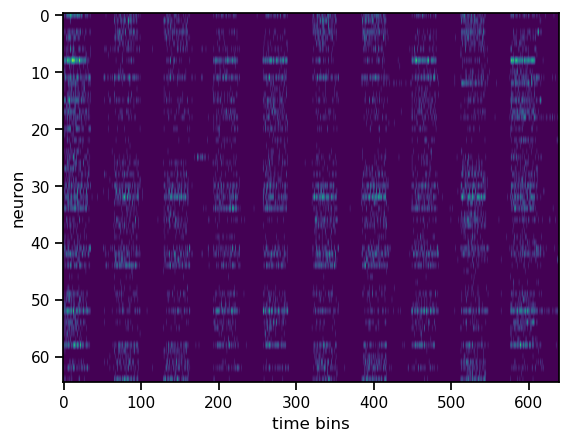

In [8]:
# Read in the matrix Msp from v1_spike_data.mat
if using_colab:
    spk_data = loadmat("/content/gdrive/MyDrive/CSE8803_ML_for_Neural_Behavioral_Data/data/v1_spike_data.mat")
else:
    spk_data = loadmat('./data/v1_spike_data.mat')
M = spk_data['Msp']

plt.figure()
plt.imshow(M[:640,:].T, aspect='auto')
plt.ylabel("neuron")
plt.xlabel("time bins")

### Compare the responses of two neurons

Plot the responses of neurons #9 and #33 (contained in columns 8 and 32 of `Msp`) over the first 640 time bins. Make the x-axis have units of seconds, and give the plot x and y-axis labels of "time (s)" and "spike count" respectively.  

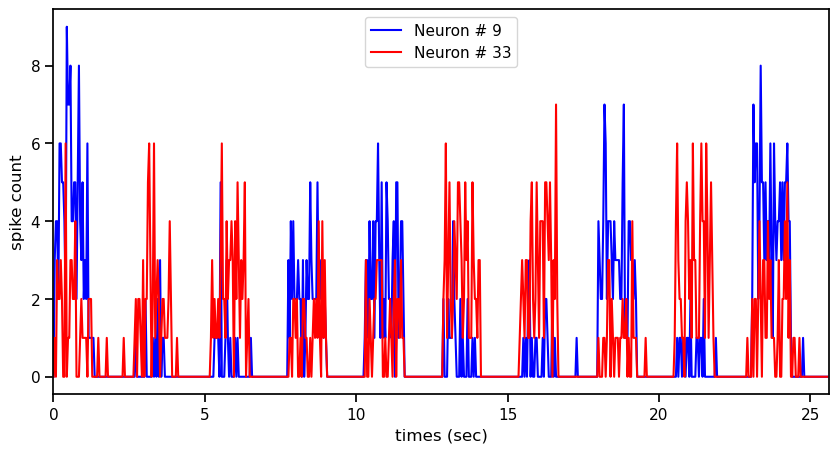

In [12]:
x = np.arange(0, 640*40, 40)/1000

plt.figure(figsize=(10,5))
plt.plot(x, M[:640,8], color = 'blue')
plt.plot(x, M[:640,32], color = 'red')
plt.xlabel("times (sec)"); plt.ylabel("spike count")
plt.xlim([0,640*40/1000]) 
plt.legend(['Neuron # 9', 'Neuron # 33'])

Make a scatter plot showing the mean spike rate of all 65 neurons in units of spikes/s. (Use `plt.annotate()` to label each scatter points with its neuron index so individual responses can be picked out).  

[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.04 0.   0.   ... 0.   0.   0.04]
 [0.08 0.   0.   ... 0.04 0.   0.04]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]] (640, 65)
[0.022125  0.01225   0.00525   0.0188125 0.012125  0.0065625 0.011
 0.0021875 0.0358375 0.0018125 0.0050625 0.0306875 0.012125  0.0033125
 0.007     0.0171875 0.0045625 0.0126875 0.0135625 0.00275   0.0088125
 0.0006875 0.0059375 0.0011875 0.003125  0.0078125 0.008     0.0065
 0.0119375 0.0059375 0.026     0.01525   0.0397875 0.0128125 0.020725
 0.0045625 0.0135    0.00875   0.0029375 0.005125  0.003875  0.019125
 0.027625  0.009125  0.0234375 0.0008125 0.0011875 0.000625  0.002375
 0.0115    0.0060625 0.005875  0.0366375 0.0030625 0.0118125 0.007875
 0.002375  0.0023125 0.030175  0.0053125 0.00425   0.0109375 0.0173125
 0.0030625 0.01875  ] (65,)


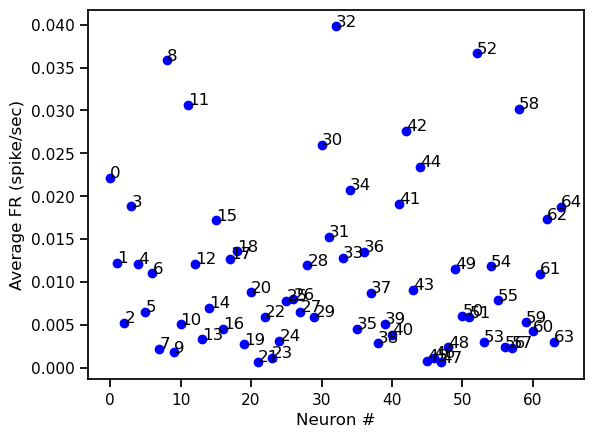

In [14]:
# get the mean spike rate in units of spikes/second (make sure the unit is correct!)
# YOUR CODE HERE
M_sec = M[:640,:]*40/1000
print(M_sec, M_sec.shape)
mean_spike = np.mean(M_sec,axis=0)
print(mean_spike, mean_spike.shape)
#raise NotImplementedError()

plt.figure()
for i, j in enumerate(mean_spike):
    plt.plot(i, j, 'bo')
    plt.annotate(str(i), (i,j))
plt.xlabel("Neuron #"); plt.ylabel(r"Average FR (spike/sec)");

In [15]:
# TEST YOUR ANSWER
assert mean_spike.shape == (65,)

## Prinicpal Components Analysis (PCA)

Start by computing the covariance of the responses. You can do this using `np.cov()`, or by subtracting off the mean response from each neuron (each column of `M`) and computing $\frac{M^TM}{n − 1}$, where $n=6400$ is the number of samples (time bins).

Compute the singular values (eigenvalues), $s_i$, of the covariance matrix with `np.linalg.svd()` or `np.linalg.eig()`. 

Plot them as a function of $i$. Do the data points live close to a subspace of dimensionality less than 65?

Make a second plot showing the "cumulative fraction of variance accounted for", showing how much of the total response variance one would capture if they kept only the first $k = 1, 2, 3, \ldots , 65$ principal components (PCs).  The $k^{th}$ value of this curve is $\frac{\sum_{i=1}^k s_i}{S_{tot}}$, where $S_{tot}$ is the sum of all the singular values.

In [17]:
# Calculate covariance and compute eigenvalues of the covariance matrix
cov = np.cov(M, rowvar=False)  # Set rowvar=False to get the correct shape for the covariance matrix

print("the covariance matrix is: ", cov)
print("the shape of covariance matrix is: ", cov.shape)
V, s, Vt = np.linalg.svd(cov)
# Vector s includes the singular values, matrix Vt represents the eigenvalues and is the transpose of V.
print("The singular values (eigenvalues) are: ", s)
print("The eigenvalues test", (s>=0).all())
print(V.shape, Vt.shape)
# YOUR CODE HERE
# raise NotImplementedError()

the covariance matrix is:  [[0.34423777 0.1437542  0.06647171 ... 0.13843022 0.02859031 0.16676424]
 [0.1437542  0.4200871  0.11014446 ... 0.12352106 0.03268277 0.29641636]
 [0.06647171 0.11014446 0.13309541 ... 0.0596601  0.01636867 0.14481452]
 ...
 [0.13843022 0.12352106 0.0596601  ... 0.31798562 0.0389176  0.16246035]
 [0.02859031 0.03268277 0.01636867 ... 0.0389176  0.06181999 0.04773868]
 [0.16676424 0.29641636 0.14481452 ... 0.16246035 0.04773868 0.56338859]]
the shape of covariance matrix is:  (65, 65)
The singular values (eigenvalues) are:  [6.57831324 1.93844924 0.62504958 0.55583198 0.46720175 0.42816651
 0.40639426 0.36218014 0.32154235 0.30554965 0.28286411 0.25121134
 0.23960852 0.22242228 0.215847   0.19903585 0.19074751 0.18114794
 0.17934783 0.17821132 0.17643233 0.17365167 0.16946326 0.16524407
 0.15598305 0.14713555 0.145461   0.14036909 0.13306606 0.1180728
 0.11392716 0.10841249 0.10753092 0.10278415 0.10148303 0.09675738
 0.09256553 0.09041777 0.0837579  0.0788244

In [18]:
# TEST YOUR ANSWER
assert (s>=0).all()

The data live in an approximately 2 dimenisonal subspace
The first 3 PCs would be needed to capture 50% of the total variance.
The first 33 PCs would be needed to capture 90% of the total variance.


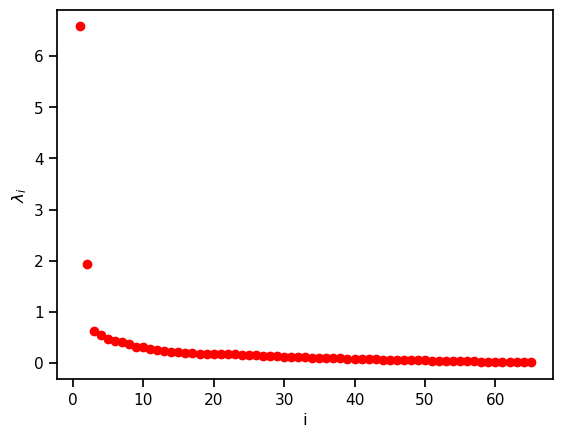

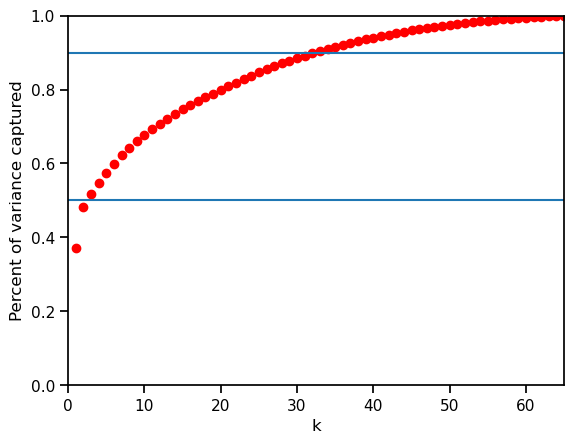

In [19]:
# Plot eigenvalues
plt.figure()
plt.plot(np.arange(len(s))+1,s, 'ro')
plt.xlabel("i"); plt.ylabel(r"$\lambda_i$")

print("The data live in an approximately 2 dimenisonal subspace")

# Plot cumulative variance captured
var_cap = np.cumsum(s)/np.sum(s)

plt.figure()
plt.plot(np.arange(len(s))+1,var_cap, 'ro')
plt.axhline(0.5); plt.axhline(0.9)
plt.xlabel("k"); plt.ylabel(r"Percent of variance captured")
plt.axis([0,65,0,1])

k50 = np.argmax(var_cap > 0.5) + 1
k90 = np.argmax(var_cap > 0.9) + 1
print("The first", k50, "PCs would be needed to capture 50% of the total variance.")
print("The first", k90, "PCs would be needed to capture 90% of the total variance.")

 Since the frist 35 PCs explain 90% of variance, most of the variance is explained by these 35 dimensions instead of the total 65 dimensions. 

### Plot the first two principal components

Plot the first PC (i.e., the first eigenvector of the covariance matrix).  This is the pattern (across the 65 neurons) that captures the *most* variance of the time-varying population response.  

1. What does the shape of this eigenvector tell you about the dominant pattern of the response?  

2. Specifically, what does it tell us that all the elements of this vector have the same sign? You might wish to compare this to the plot of the average spike rate across neurons you made above.

*Note:* The sign of the PCs is irrelevant, since the negative of an eigenvector is also an eigenvector, so if you see that your first PC has mostly negative values I'd recommend flipping its sign so that the curve you plot has mostly positive values, which is easier to interpret.



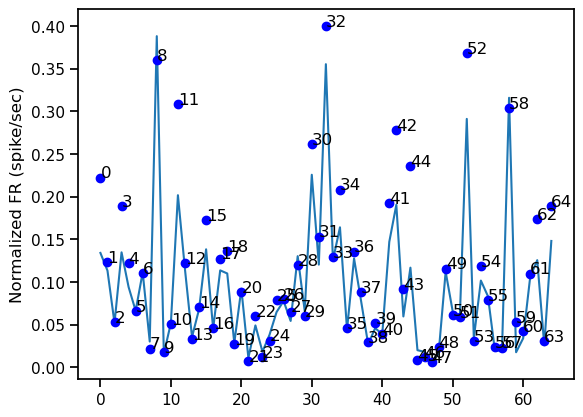

In [22]:
# Plot negative of first eigenvector
plt.figure()
plt.plot(-Vt[0])

# Overlay mean spike rates, normalized to be on same y-axis scale (unnecessary)
normalized_spike = mean_spike/np.max(mean_spike) * 0.4
for i, j in enumerate(normalized_spike):
    plt.plot(i, j, 'bo')
    plt.annotate(str(i), (i,j))
    
plt.ylabel(r"Normalized FR (spike/sec)");

#### Answer the two questions above:

<span style="color:red">Your answer:</span>1- The shape of the eigen ventor tells us that most of the variance is explained by the first half of the time bins, 0:3200, and from 3200:6400 it is zero. This could mean that the sine grating stimuli had differential neural responses in contrast to the blank screen response.2- Comparing the normalized spike rate with the previous average spike rate, it shows that the 5% normalized firing rate explains the differential neural response to sine grating stimuli vs. blank screen. Also, the positive  (or all negative)sign shows that the positive firing rate explains the differential neuron response.


1- The shape of the eigen ventor tells us that most of the variance is explained by the first half of the time bins, 0:3200, and from 3200:6400 it is zero. This could mean that the sine grating stimuli had differential neural responses in contrast to the blank screen response. 
2- Comparing the normalized spike rate with the previous average spike rate, it shows that the 5% normalized firing rate explains the differential neural response to sine grating stimuli vs. blank screen. Also, the positive (or all negative) sign shows that the positive firing rate explains the differential neuron response. 

### Plot the second PC.  

1. Does it look similar or different to the first PC?

2. Do neurons 9 and 33 (the two you looked at above) have similar or different loading onto this PC (i.e., do they have weights of the same or opposite sign?)

In [28]:
print(Vt[1].shape)

(65,)


The loading of neuron #9: 0.5363531168971981
The loading of neuron #33: -0.33177933810267773


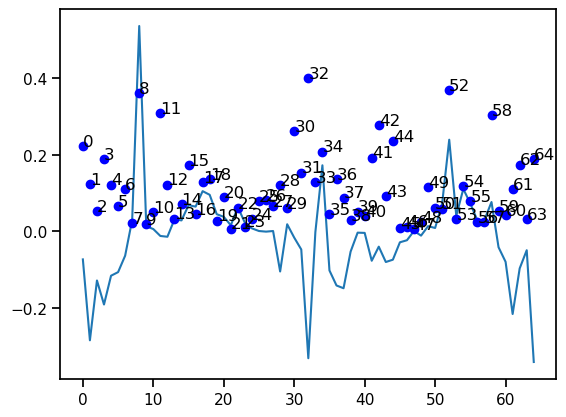

In [30]:
# Plot second eigenvector
plt.figure()
plt.plot(Vt[1])

for i, j in enumerate(normalized_spike):
    plt.plot(i, j, 'bo')
    plt.annotate(str(i), (i,j))
    
# Pick out particular eigenvector loadings
print("The loading of neuron #9:", Vt[1][8])
print("The loading of neuron #33:", Vt[1][32])

#### Answer the two questions above:

<span style="color:red">Your answer:</span>The second eigenvector represents the neurons whose firing rate both increased and decreased in response to sine grating stimuli. The neuron 9 and 33 (8 and 32 on the plots) had very high firing rate, while the second PC vector shows that neuron 9 explains 0.03 of variance and neuron 33 0.33 and neuron33 has a negative signs. Therefore, they could have differential response to the stimuli. For exmaple, one could fire to peak of sinusoidal grading and one in response to the through. 

The second eigenvector represents the neurons whose firing rate both increased and decreased in response to sine grating stimuli.
The neuron 9 and 33 (8 and 32 on the plots) had very high firing rate, while the second PC vector shows that neuron 9 explains 0.54 of variance and neuron 33 0.33 and neuron33 has a negative signs. Therefore, they could have differential response to the stimuli. For exmaple, one could fire to peak of sinusoidal grading and one in response to the through. 

### Plot the data projections onto the first two PCs

Make a scatter plot showing the scatter plot of the data onto the first two principal components. That is, plot the dot product of each data vector with the first component versus its dot product with the second component. 

These projections can be computed very easily by the matrix multiplications $M_0 u_1$ and $M_0 u_2$, where $u_1$ and $u_2$ are the first two PCs, and $M_0$ is $M$ with the mean response of each neuron subtracted off.  

1. Describe the structure observed in this plot.  Can you speculate about what is going on? (Refer to experiment description at the top, if necessary).

(6400, 65) (65,) (65, 65)
(6400,) (6400,)


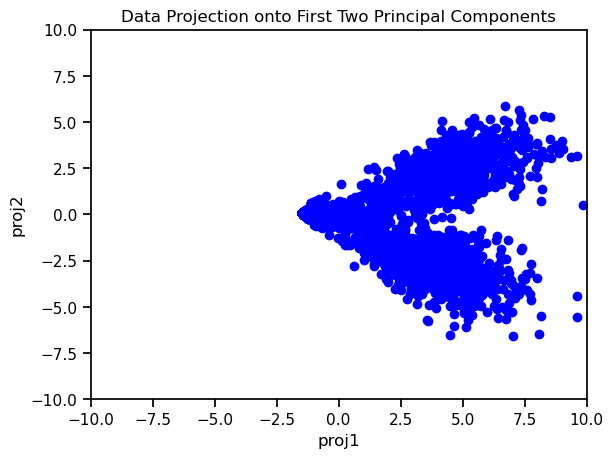

In [43]:
# Compute the data projections onto the first two PCs
### 
# YOUR CODE BELOW
no_mean = M - np.mean(M,axis=0)
print(no_mean.shape, Vt[0].shape, V.shape)
proj1 = np.dot(no_mean, -V[:,0])
proj2 = np.dot(no_mean, V[:,1])
print(proj1.shape, proj2.shape)
### 

# Plot projection of mean corrected data on to first 2 eigenvectors
plt.figure()
plt.plot(proj1, proj2, 'bo')
plt.axis([-10,10,-10,10]);
plt.xlabel("proj1"); plt.ylabel("proj2");
plt.title("Data Projection onto First Two Principal Components")
plt.show()

#### Answer the question above:

<span style="color:red">Your answer:</span>An arrow shape pattern emerges that reflects the neural spikes in response to the drifiting sinusoidal stimuli.

An arrow shape pattern emerges that reflects the neural spikes in response to the drifiting sinusoidal stimuli.  

### Plot the time traces of the projections onto the first two PCs over time for the first 2 stimuli (128 time bins). 

You should have two lines, one for proj1 and the other for proj2, plotted against time.

1. What information do you think is conveyed by the first projection? The second projection?  


(6400, 65) (65,)
(128,) (128,)


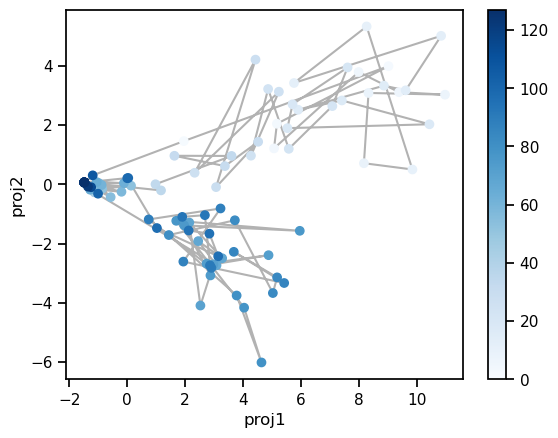

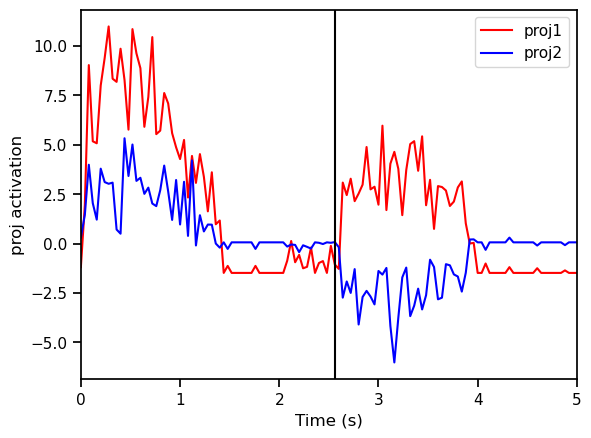

In [48]:
# Caclulate first two eigenvector projection for first tbins time bins
tbins = 128
# proj1 = M[:tbins] @ -Vt[0]
# proj2 = M[:tbins] @ Vt[1]
no_mean = M - np.mean(M,axis=0)
print(no_mean.shape, Vt[0].shape)
proj1 = np.dot(no_mean, -V[:, 0])[:tbins]
proj2 = np.dot(no_mean, V[:, 1])[:tbins]
print(proj1.shape, proj2.shape)
# Plot proj1 vs. proj2 to see the time trajectory (indicated by color shading)
plt.figure()
plt.plot(proj1, proj2, 'k-', alpha=0.3, zorder=-1)
plt.scatter(proj1, proj2, c=np.arange(tbins) , cmap='Blues') #np.arange(tbins)
plt.colorbar()
plt.xlabel("proj1"); plt.ylabel("proj2")

# Plot proj1 & proj2 against time
plt.figure()
time = np.arange(0,tbins*40,40)/1000
plt.plot(time, proj1, 'r-', label="proj1")
plt.plot(time, proj2, 'b-', label="proj2")
plt.xlabel("Time (s)"); plt.ylabel("proj activation")
plt.axvline(time[64], color="black")
plt.xlim([0,5])
plt.legend();

#### Answer the question above:

<span style="color:red">Your answer:</span>The first projection could represent the spatial location of the stimulus, while the second projection represents the temporal information. Most of the top points are the ealier samples and the bottom half are the later samples. The second plot shows that there is a flip in the projection activation at 2.5 second (64/128 samples). This could be that at 2.5 seconds the visual grading changed and resulted in opposit neural response. 


The first projection could represent the spatial location of the stimulus, while the second projection represents the temporal information. Most of the top points are the ealier samples and the bottom half are the later samples. The second plot shows that there is a flip in the projection activation at 2.5 second (64/128 samples). This could be that at 2.5 seconds the visual grading changed and resulted in opposit neural response. 

## Autoencoder

---
Autoencoder is a neural network for dimensionality reduction. The idea is that you train a neural network with the same data as inputs and outputs, but use an intermediate hidden layer (or layers) with dimensionality smaller than the original data. This forces the data through a "bottleneck" where it is represented in a low-dimensional form. This has numerous advantages:

* projectable and invertible - the link between the high/low dimensional representation is defined by the neural net
* fast and scalable - neural networks are computationally efficient
* non-linear and unsupervised - the autoencoder learns the non-linear manifold without needing labels

---

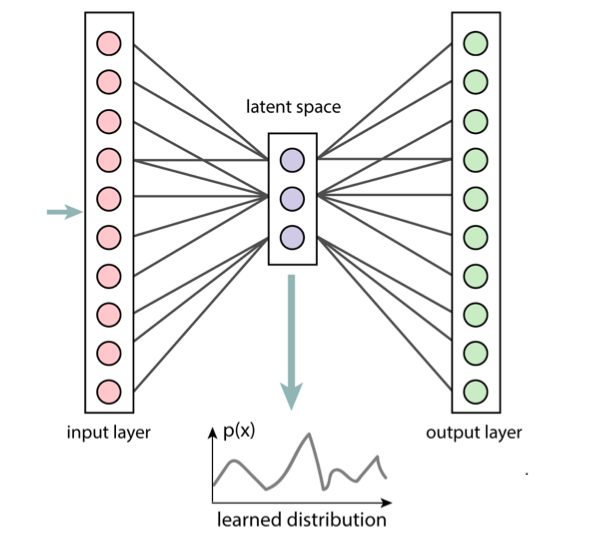

### Data Preprocessing

First, since we are dealing with Pytorch, it's necessary to pass in our data as a tensor of floats, and also remember to standardize the data.

Hint: a tensor is a container that stores data in $p$ dimensions. A matrix is a special case of a tensor that is 2D.

In [55]:
torch.manual_seed(0)
num_stimulus = 25

neural_data_standardized = MinMaxScaler().fit_transform(M[:num_stimulus*64,:]) # 25 stimulus
neural_data_float_tensor = torch.tensor(neural_data_standardized).float()

print(neural_data_float_tensor.shape)

torch.Size([1600, 65])


We need to create a custom dataset class that allows us to load our data into a pytorch data loader. Then, apply the custom dataset class to the neural data tensor.

Then, we will break the data into a train (90% of the data) and validation (10% of the data) split.

Finally, we should make a train data loader and a validation data loader, and set the batch size to be 200.

In [58]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        instance = self.data[idx, :]
        sample = {"data": instance}
        return sample

train_stimulus = np.random.choice(np.arange(num_stimulus), size=int(0.9*num_stimulus), replace=False)
validation_stimulus = np.delete(np.arange(num_stimulus), train_stimulus)

train_data = []
for index in train_stimulus:
    train_data.append(neural_data_float_tensor[index*64:(index+1)*64,:])
train_data = np.array(train_data).reshape(-1, neural_data_float_tensor.shape[1])

validation_data = []
for index in validation_stimulus:
    validation_data.append(neural_data_float_tensor[index*64:(index+1)*64,:])
validation_data = np.array(validation_data).reshape(-1,neural_data_float_tensor.shape[1])

train_dataset = CustomDataset(torch.tensor(train_data, dtype=torch.float32, device=device))
validation_dataset = CustomDataset(torch.tensor(validation_data, dtype=torch.float32, device=device))

print(len(train_data), len(validation_data))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=200, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size=200, shuffle=True)

1408 192


### Build the Autoencoder

In [61]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Implementing a linear encoder.
        # Each layer is composed of a linear layer followed by a Relu activation function.
        # The last layer is just a linear layer!
        # We take a data point from a dimension of 65, to 10, to 2.

        self.encoder = torch.nn.Sequential(
         torch.nn.Linear(65,10),
         torch.nn.ReLU(),
         torch.nn.Linear(10, 2)
        )
        # YOUR CODE HERE
        # raise NotImplementedError()

        # Implementing a linear decoder (as opposed to a convolutional decoder, etc.).
        # Decoder is composed of a linear layer followed by a Relu activation function, repeated several times.
        # We take a data point from a dimension of 2, to 10, to 65.
        
        self.decoder = torch.nn.Sequential(
         torch.nn.Linear(2,10),
         torch.nn.ReLU(),
         torch.nn.Linear(10,65),
         torch.nn.ReLU()
        )
        # YOUR CODE HERE
        # raise NotImplementedError()

    def forward(self, x):
        latent_variables = self.encoder(x)
        reconstruction_data = self.decoder(latent_variables)
        return reconstruction_data

In [63]:
# TEST YOUR ANSWER
torch.manual_seed(0)
model = Autoencoder().to(device)
output = model(torch.tensor(train_data, device=device))
assert output.shape == train_data.shape

### Train the Autoencoder

In [66]:
model = Autoencoder().to(device)
model, training_losses, validation_losses = train_ae(model, train_loader, validation_loader, device, epochs=500)

# get the whole reconstructed neural data, here train_dataset.dataset.data is the whole dataset 18561 x 115.
reconstructed_data = model(train_dataset.data.to(device))
# get the latent variables of fist 3 stimulus
latent_variables = model.encoder(neural_data_float_tensor[:3*64, :].to(device))

epoch desc:   0%|          | 0/500 [00:00<?, ?it/s]

### Plot the Training and Validation Losses


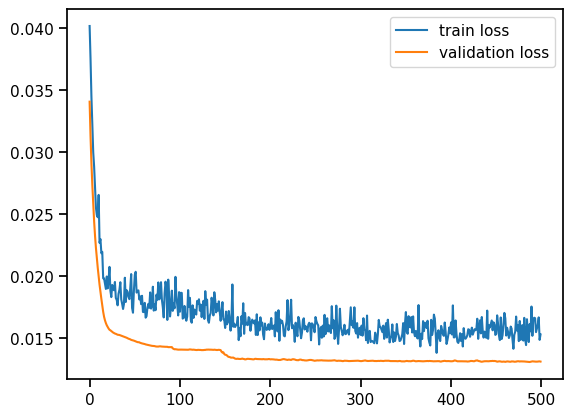

In [68]:
plt.figure()
plt.plot(training_losses, label="train loss")
plt.plot(validation_losses, label="validation loss")
plt.legend()

### Compare the Original Neural Data and the Reconstruction Neural Data

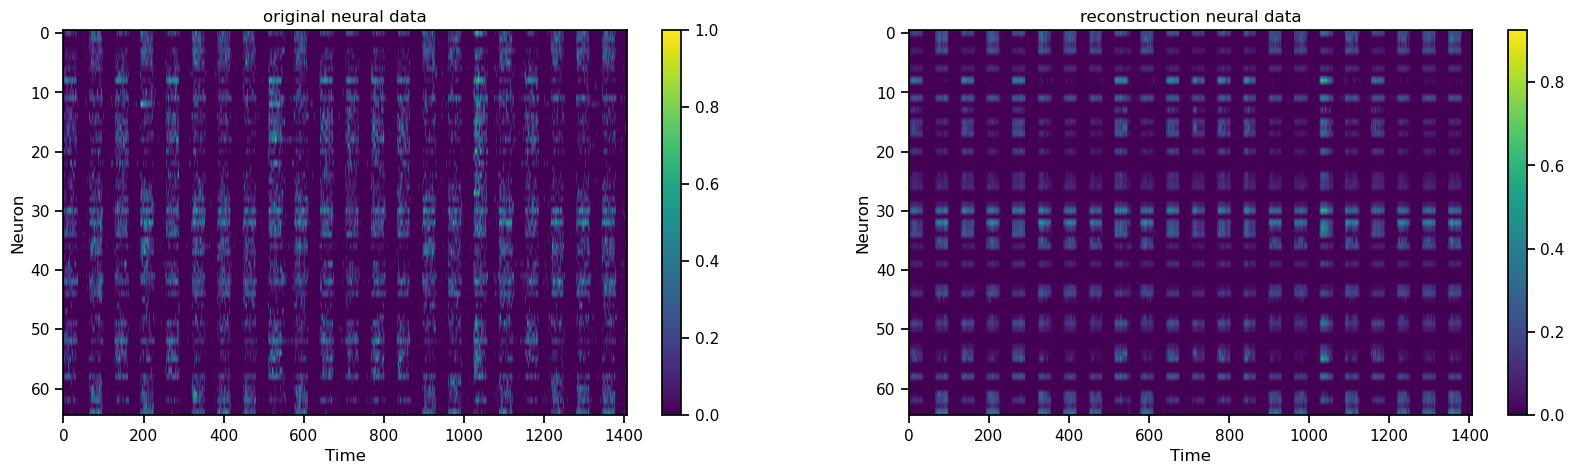

In [70]:
reconstructed_neural_data = reconstructed_data.cpu().detach().numpy().T
original_data = train_dataset.data.cpu().numpy().T

fig, axs = plt.subplots(1,2,figsize=(20, 5))
im = axs[0].imshow(original_data, aspect='auto') # original
fig.colorbar(im, orientation='vertical')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Neuron')
axs[0].set_title('original neural data')
im = axs[1].imshow(reconstructed_neural_data, aspect='auto') # reconstruction
fig.colorbar(im, orientation='vertical')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Neuron')
axs[1].set_title('reconstruction neural data');

### Plot the First Two Latent Variables

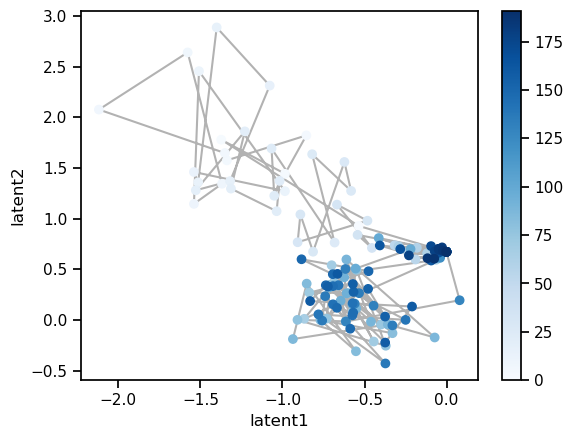

In [72]:
latent_variables_cpu = latent_variables.cpu().detach().numpy()
latent1 = latent_variables_cpu[:, 0]
latent2 = latent_variables_cpu[:, 1]

plt.figure()
plt.plot(latent1, latent2, 'k-', alpha=0.3, zorder=-1)
plt.scatter(latent1, latent2, c= np.arange(len(latent1)), cmap='Blues')
plt.colorbar()
plt.xlabel("latent1"); plt.ylabel("latent2");

## Gaussian Process Factor Analysis (GPFA) (optional!)

---

### Factor Analysis (FA)

Factor analysis (FA) attempts to summarize the collective activity of a population of $N$ neurons recorded over $T$ time points using a smaller number of $D$ latent dimensions.
Similar to how we could formulate a Gaussian process as a 'latent function' to be inferred in order to explain a set of observations, we can treat FA as a problem of learning and inference in a probabilistic generative model.

In the generative model of factor analysis, the latents $X$ are _Gaussian iid_ and the firing rates $F$ are linear functions of the latents.
Finally, the actual observations $Y$ are are given by the firing rates corrupted by Gaussian noise.
We can write this mathematically as follows:

${Y} \in \mathbb{R}^{N \times T}$ (data)\
${X} \in \mathbb{R}^{D \times T}$ (latent variables)\
${C} \in \mathbb{R}^{N \times D}$ (readout matrix)

${x}_{dt} \sim \mathcal{N}(x; \mu = 0, \sigma^2=1)$ \
${y}_{nt |{C}, {\bf X}} \sim \mathcal{N}(y_{nt}; \mu = ({CX})_{nt}, \sigma_n^2)$

The corresponding marginal likelihood has a simple closed-form solution that factorizes across time:
$\log p ({Y}) = \log \int p({Y} | {X}) p({X}) d{X} = \sum_t \log \mathcal{N}({y}_t; {\mu} = 0, {\Sigma} = {C C}^T)$

This is convenient since we recall from previously that we will need to maximize this marginal likelihood with respect to our parameters to train the model (in practice there are out-of-the-box libraries such as scikit-learn which do this efficiently and robustly).

### Gaussian Process Factor Analysis (GPFA)

Gaussian process factor analysis (GPFA) attempts to ameliorate the assumption of FA that the latent states are independent across time.
This is desirable since behavioral and (presumably) cognitive processes unfold over time so we expect their latent dynamics to also be continuous in time.
Additionally, as we saw previously, building such prior information into our models can help denoise and improve inference over our hidden states.

GPFA is thus defined by a generative model where the latents $X$ are drawn from a _Gaussian process_ which introduces correlations over time.
The firing rates $F$ are linear functions of the latents as in FA, and the observation noise is still Gaussian.
Formally, we can write our generative model as follows:

${Y} \in \mathbb{R}^{N \times T}$ (data)\
${X} \in \mathbb{R}^{D \times T}$ (latent variables)\
${C} \in \mathbb{R}^{N \times D}$ (readout matrix)

${x}_d \sim \mathcal{GP}(0, K_{\text{RBF}})$, where $K_{\text{RBF}} = \exp(-\frac{(t-t^{'})^2}{2\sigma^{2}})$ is the RBF kernel function. \
${y}_{nt |{C}, {X}} \sim \mathcal{N}(y_{nt}; \mu = ({CX})_{nt}, \sigma_n^2)$

Everything is still jointly Gaussian and the marginal likelihood for GPFA also has a closed-form expression:\
$\log p ({Y}) = \log \int p({Y} | {X}) p({X}) d{X} = \log \mathcal{N}(vec({Y}); { \mu} = 0, {\Sigma} = {\bf K}_{yy})$

However, the marginal likelihood no longer factorizes across time and ${K}_{yy} \in \mathbb{R}^{NT \times NT}$ is rank $DT$.
This leads to a computational complexity of $\mathcal{O}(D^3 T^3)$ which can be prohibitive for longer time series.

---

### GPFA from a Generative Modeling Perspective

Here we provide a brief example to GPFA from a generative modeling perspective. Following the steps in Section 2:

1. Sample the latent variables ${X}$ from a _Gaussian Process_ using RBF kernel function.

2. Project the latent variables into a high-dimensional space using ${C} \in \mathbb{R}^{N \times D}$.

3. Create the observations ${Y}$ with Gaussian noise by: ${y}_{nt |{C}, {X}} \sim \mathcal{N}(y_{nt}; \mu = ({CX})_{nt}, \sigma_n^2)$.

In [187]:
# parameters
T = 100 # number of time points
N = 20 # number of neurons
D = 2 # latent dimensionality
C = np.random.uniform(-1, 1, (N, D)) # loading matrix
sigma_n = np.random.uniform(0.2, 0.75, N) # noise parameters
ts = np.arange(T) # time series
sigma = 10 # timescale in RBF kernel function

First, we create the RBF kernel function, resulting in a $\mathbb{R}^{T \times T}$ covariance matrix $K$.

In [190]:
# compute the RBF kernel
# Compute pairwise differences (t - t')^2 for each time point
# Create a distance matrix using broadcasting
t_diff = ts[:, None] - ts[None, :]  # Shape (T, T), pairwise differences between time points
t_diff_sq = t_diff ** 2  # Square the differences
print(t_diff, t_diff.shape)
# Compute the RBF kernel matrix using the squared differences
K = np.exp(-t_diff_sq / (2 * sigma**2))  # Shape (T, T)

# Verify the kernel matrix shape and visualize it
print("Kernel matrix shape:", K.shape)
# YOUR CODE HERE
# raise NotImplementedError()

[[  0  -1  -2 ... -97 -98 -99]
 [  1   0  -1 ... -96 -97 -98]
 [  2   1   0 ... -95 -96 -97]
 ...
 [ 97  96  95 ...   0  -1  -2]
 [ 98  97  96 ...   1   0  -1]
 [ 99  98  97 ...   2   1   0]] (100, 100)
Kernel matrix shape: (100, 100)


In [192]:
# TEST YOUR ANSWER
assert K.shape == (100, 100)

Then, we generate the latent variables $X$ using the _Gaussian Process_ with RBF kernel $K$.

Hint: if $X \sim \mathcal{N}(0, K)$, then we have $X = LZ$, where $Z \sim \mathcal{N}(0, I)$. 

$L$ can be computed by cholesky decomposition with $K=LL^{T}$

In [195]:
# compute L and X
L = np.linalg.cholesky(K+1e-8*np.eye(T)) #add a small number to prevent numerical issue
print(L.shape)
Z = np.random.normal(0,1,(D,T)) # shape (D,T) = (2,100) 
print(Z.shape)
X = np.dot(L, Z.T).T
print(X.shape)
# YOUR CODE HERE
# raise NotImplementedError()

(100, 100)
(2, 100)
(2, 100)


In [197]:
# TEST YOUR ANSWER
assert X.shape == (2, 100)

Finally, we map the latent variables into a high-dimensional space using ${C}$, and create observations ${Y}$ with Gaussian noise.

In [200]:
# map the latent variables to create observations
print(C.shape)
F = np.dot(C, X) # mapping X using C
epsilon = np.random.normal(0, sigma_n, (T, N)).T
Y = F + epsilon
print(Y.shape)
# YOUR CODE HERE
# raise NotImplementedError()

(20, 2)
(20, 100)


In [202]:
# TEST YOUR ANSWER
assert Y.shape == (20, 100)

### Plot the Latent Variables $X$ and Observations $Y$

Text(0, 0.5, 'neurons')

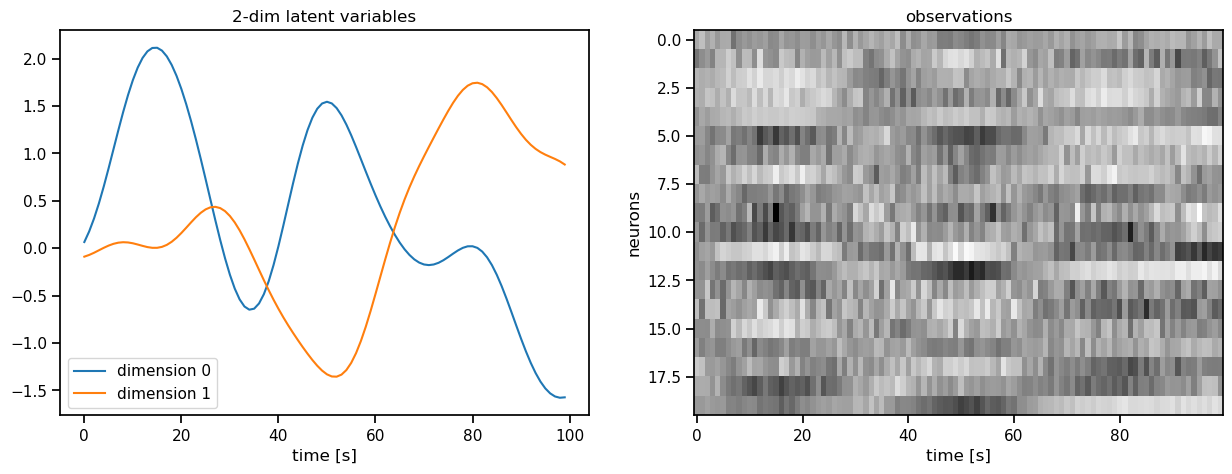

In [205]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

axs[0].set_title('2-dim latent variables')
axs[0].set_xlabel('time [s]')
for i, y in enumerate(X):
    axs[0].plot(ts, y, label=f'dimension {i}')
axs[0].legend()

axs[1].imshow(Y, cmap='Greys', aspect='auto')
axs[1].set_title('observations')
axs[1].set_xlabel('time [s]')
axs[1].set_ylabel('neurons')

### Generate Synthetic Spike Train Dataset

A synthetic spike trains could be generated by 4 steps as follows:

1. Create a time series of a 2-dimensional harmonic oscillator as latent variables.

2. Project the latent variables into a high-dimensional space via a random projection.

3. The resulting high-dimensional time series serves as time-dependent rates for an inhomogeneous multivariate Poisson process.

4. Multiple realizations of this Poisson process, which mimic spike trains from multiple trials, serve as the generated spike train data to the GPFA.

In [208]:
num_trials = 20
num_neurons = 50
times_oscillator, oscillator_latent_2dim, spiketrains_oscillator = generate_syn_data(num_trials, num_neurons)

### Plot the Synthetic Spike Train Dataset

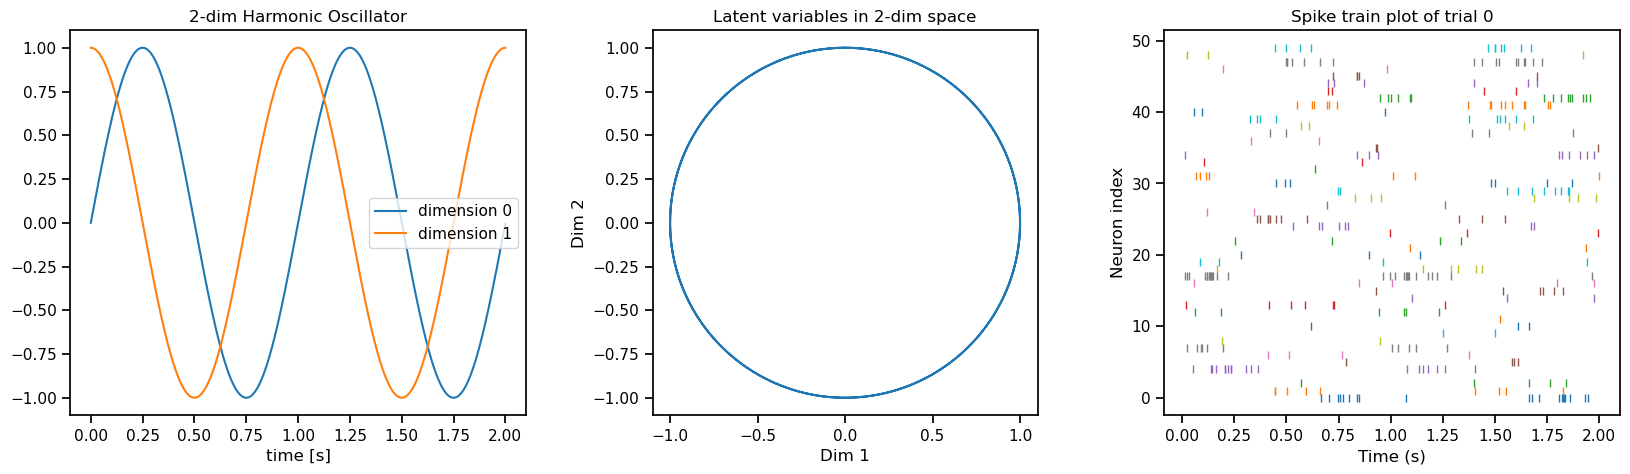

In [210]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

axs[0].set_title('2-dim Harmonic Oscillator')
axs[0].set_xlabel('time [s]')
for i, y in enumerate(oscillator_latent_2dim):
    axs[0].plot(times_oscillator, y, label=f'dimension {i}')
axs[0].legend()

axs[1].set_title('Latent variables in 2-dim space')
axs[1].set_xlabel('Dim 1')
axs[1].set_ylabel('Dim 2')
axs[1].set_aspect(1)
axs[1].plot(oscillator_latent_2dim[0], oscillator_latent_2dim[1])

trial_to_plot = 0
axs[2].set_title(f'Spike train plot of trial {trial_to_plot}')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Neuron index')
for i, spiketrain in enumerate(spiketrains_oscillator[trial_to_plot]):
    axs[2].plot(spiketrain, np.ones_like(spiketrain) * i, ls='', marker='|')

### Perform GPFA on the Synthetic Spike Train Data

First, we need to create a GPFA instance.

Hint: use the GPFA in elephant package. Set the x_dim (the dimensionality of latent variables) to be 2.

In [212]:
# create the gpfa instance
gpfa = GPFA(x_dim=2)

Then, we need to fit the GPFA using the synthetic spike train data.

Hint: use the first half of the trials for training.

In [214]:
gpfa.fit(spiketrains_oscillator[:num_trials//2])

# print parameters
print(gpfa.params_estimated.keys())

Initializing parameters using factor analysis...

Fitting GPFA model...
dict_keys(['covType', 'gamma', 'eps', 'd', 'C', 'R', 'notes'])


Next, we use the remaining half of the trials as testing data, and extract their corresponding latent variables from the GPFA model.

Hint: use the transform() method in gpfa instance.

In [219]:
latent_variables  = gpfa.transform(spiketrains_oscillator[num_trials//2:])

### Plot the Learned and the Original Latent Variables

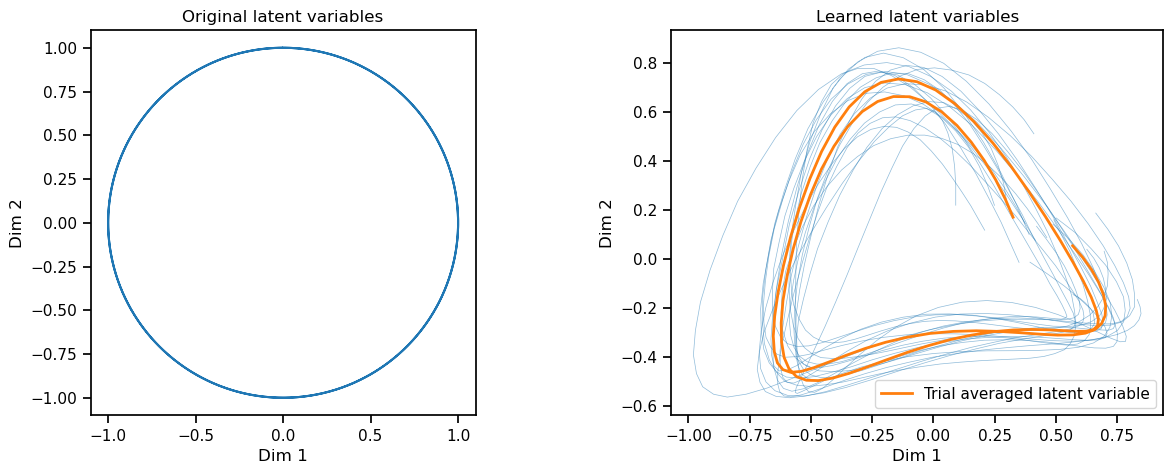

In [221]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

linewidth_single_trial = 0.5
color_single_trial = 'C0'
alpha_single_trial = 0.5

linewidth_trial_average = 2
color_trial_average = 'C1'

axs[0].set_title('Original latent variables')
axs[0].set_xlabel('Dim 1')
axs[0].set_ylabel('Dim 2')
axs[0].set_aspect(1)
axs[0].plot(oscillator_latent_2dim[0], oscillator_latent_2dim[1])

axs[1].set_title('Learned latent variables')
axs[1].set_xlabel('Dim 1')
axs[1].set_ylabel('Dim 2')
axs[1].set_aspect(1)
# single trial latent variable
for single_trial_latent in latent_variables:
    axs[1].plot(single_trial_latent[0], single_trial_latent[1], '-', lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
# trial averaged latent variable
average_latent_variable = np.mean(latent_variables, axis=0)
axs[1].plot(average_latent_variable[0], average_latent_variable[1], '-', lw=linewidth_trial_average, c=color_trial_average, label='Trial averaged latent variable')
axs[1].legend()